In [1]:
from langgraph.graph import START, END, StateGraph
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [2]:
load_dotenv()
import os

In [3]:
def groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

model = groq_llm()

In [4]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")

In [5]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="The category of issue mentioned in the review")
    tone: Literal["angry", "frustated", "disappointed", "calm"] = Field(description="The emotional tone expressed by the user")
    urgency: Literal["low", "medium", "high"] = Field(description="How urgent or critical the issue appears to be")

In [6]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model_2 = model.with_structured_output(DiagnosisSchema)

In [7]:
prompt = "It was really a bad product"
structured_model.invoke(prompt).sentiment

'negative'

In [8]:
result = structured_model_2.invoke(prompt)
print(result)

issue_type='Other' tone='disappointed' urgency='low'


In [9]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [14]:
def find_sentiment(state: ReviewState):
    prompt = f"For the following review find out the sentiment \n {state["review"]}"
    sentiment = structured_model.invoke(prompt).sentiment

    return {"sentiment": sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive", "negative"]:
    if state['sentiment'] == 'positive':
        return "positive"
    else:
        return "negative"

def positive_response(state: ReviewState):
    prompt = f"""Write a warm thankyou message in response to this review:
    \n\n"{state["review"]}\"\n
    Also, kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt).content

    return {"response": response}

def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review:\n\n"{state["review"]}"\n
    Return issue_type, tone and urgency"""

    response = structured_model_2.invoke(prompt)

    return {"diagnosis": response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state["diagnosis"]

    prompt = f"""You are a support assistant.
    The user had a "{diagnosis["issue_type"]}" issue, sounded "{diagnosis["tone"]}", and marked urgency as "{diagnosis["urgency"]}". 
    Write an empathetic, helpful resolution message"""

    response = model.invoke(prompt).content

    return {"response": response}

In [15]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)

graph.add_edge(START, "find_sentiment")

graph.add_conditional_edges(
    "find_sentiment",
    check_sentiment,
    {
        "positive": "positive_response",
        "negative": "run_diagnosis" 
    }
)

graph.add_edge("positive_response", END)

graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

workflow = graph.compile()

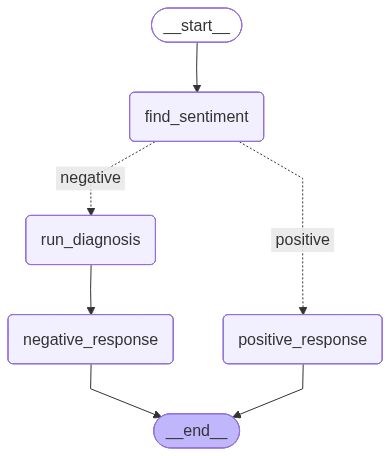

In [16]:
workflow

In [18]:
initial_state = {
    "review": "I've been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
final_state = workflow.invoke(initial_state)
final_state

{'review': "I've been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.",
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustated', 'urgency': 'high'},
 'response': 'Hi there,\n\nI’m really sorry you’re running into this issue—bugs can be incredibly frustrating, especially when they’re happening on a tight deadline. I want to get this sorted for you as quickly as possible.\n\n**Here’s what we can do right now:**\n\n1. **Quick Check‑Ins**  \n   - **What’s the exact error message?** If you can copy/paste it or take a screenshot, that will help us pinpoint the problem.  \n   - **When did the bug first appear?** Knowing the timeline can sometimes reveal recent changes or updates that triggered it.  \n   - **Which environment are you on?** (e.g., production, staging, local dev) and the OS/Browser ve

In [21]:
initial_state = {
    "review": "The new update is fantastic! The app runs so much better now, and I love the new feature you have added. Great job!"
}
response = workflow.invoke(initial_state)
response

{'review': 'The new update is fantastic! The app runs so much better now, and I love the new feature you have added. Great job!',
 'sentiment': 'positive',
 'response': 'Hey there!  \n\nThank you so much for your awesome feedback – we’re thrilled to hear that the new update is making a difference and that you’re enjoying the new feature. Your support means the world to us, and it’s feedback like yours that keeps us motivated to keep improving.  \n\nIf you have a minute, we’d love to hear more about your experience on our website. Just head over to https://www.example.com/feedback and drop us a quick note – it helps us keep the app running smoothly for everyone.  \n\nThanks again for being such a fantastic part of our community!  \n\nWarm regards,  \n[Your Team]'}

In [22]:
def result(user_input: str) -> str:
    diction = {"review": user_input}
    response = workflow.invoke(diction)
    answer = response["response"]
    return answer

In [23]:
result("The new update is fantastic! The app runs so much better now, and I love the new feature you have added. Great job!")

'Thank you so much for your wonderful feedback!  \nWe’re thrilled to hear that the new update is running smoothly and that you love the added feature. Your support and enthusiasm mean the world to us.\n\nIf you have a moment, we’d be grateful if you could share your thoughts on our website as well. Your feedback helps us keep improving and ensures we’re meeting the needs of users like you.\n\nThanks again for being part of our community!'